# Exploratory Analysis

In [187]:
import pandas as pd
import nltk
import string
import math

from wordcloud import WordCloud
from scipy.stats import kruskal, f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [5]:
df = pd.read_csv("take-home-dataset.csv", index_col="ID")
results = pd.read_csv("/Users/liamgeron/Downloads/Take Home Project.csv")

## Lets clean the data

### Strip some unnecessary whitespaces

In [6]:
results["Generation"] = results["Generation"].apply(lambda x: x.strip("\t"))
results["Generation"] = results["Generation"].apply(lambda x: x.strip("\n"))

### Organize our column names a bit

In [23]:
results.columns = ['worker_id', 'ID', 'Prompt', 'Generation', 'Phrasing', 'Topic', 'Humanness', 'tokenized']

### We can also do some tokenization here for our analysis later on

In [8]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')


results["tokenized"] = results["Generation"].apply(lambda x: sent_detector.tokenize(x.strip()))

### We're only interested in results where the generation is >= 1 sentence long

In [70]:
results = results[results["tokenized"].apply(len) >= 1]

## Let's take a look at the data!

### How many unique prompts do we have?

In [14]:
len(results["Prompt"].unique())

45

### 45 of our 180 prompts are unique

### Lets see if there's any pattern to these unique prompts (hypothesis is that certain prompts are easier/harder to generate responses from)

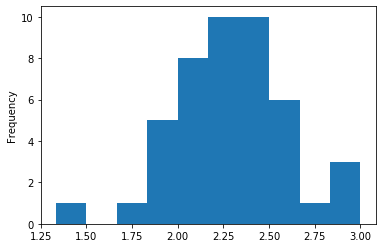

In [30]:
results.groupby("Prompt", as_index=False).mean()["Phrasing"].plot.hist()

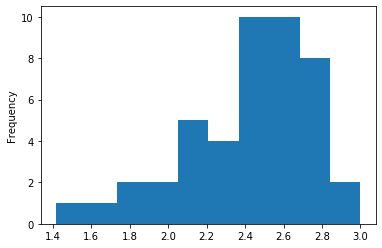

In [29]:
results.groupby("Prompt", as_index=False).mean()["Topic"].plot.hist()

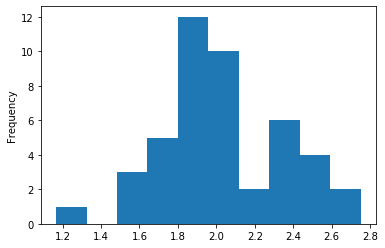

In [28]:
results.groupby("Prompt", as_index=False).mean()["Humanness"].plot.hist()

## We can see that where phrasing and topic are more or less normally distributed, the humanity is more right skewed ("humanity" is much harder for the model to achieve than syntactic and semantic accuracy)

## Lets take a look at how grouping by the generated phrases looks

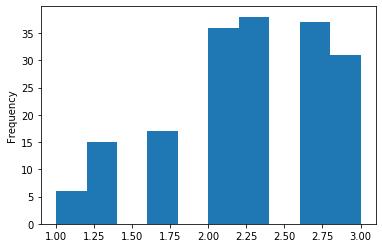

In [37]:
results.groupby("Generation", as_index=False).mean()["Phrasing"].plot.hist()

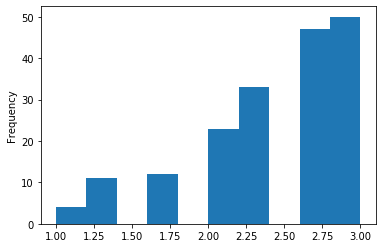

In [32]:
results.groupby("Generation", as_index=False).mean()["Topic"].plot.hist()

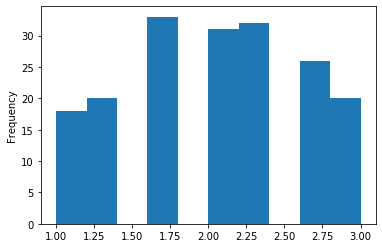

In [33]:
results.groupby("Generation", as_index=False).mean()["Humanness"].plot.hist()

### We can see more complicated distributions here, where both phrasing and topic are left skewed (i.e. have a higher tendancy to be good) and humanness is much more evenly distributed

# Let's try and extract some features to look at from our data

## My hypothesis is that features like average sentence length and overall length of the generation will significantly impact whether it was rated as good or bad

In [39]:
results["gen_len"] = results["Generation"].apply(lambda x: len(nltk.word_tokenize(x)))

In [72]:
results["avg_sent_len"] = results["tokenized"].apply(lambda x: sum([len(nltk.word_tokenize(s)) for s in x])/len(x))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Intuitively another feature that may be informative is the ratio of unique words/total words (if there is a higher concentration of unique informative words, I would hypothesize that the response may be more human)

In [88]:
stopwords = nltk.corpus.stopwords.words('english')

results["unique_word_ratio"] = results["Generation"].apply(lambda x: len(set(w for w in nltk.word_tokenize(x) if w not in string.punctuation and w not in stopwords))/len([w for w in nltk.word_tokenize(x) if w not in string.punctuation and w not in stopwords]))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Lets also take a look at some POS tagging derived features 

In [96]:
results["pos"] = results["Generation"].apply(lambda x: [l for (s, l) in nltk.pos_tag(nltk.word_tokenize(x))])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [100]:
results["pos_counts"] = results["pos"].apply(lambda x: nltk.FreqDist(x))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## TFIDF exploration

In [105]:
def tf(term, doc):
    '''
    :param term: string of desired term
    :param doc: list of tokenized words
    :return: number of instances of term in doc regularized by the length
    '''
    return doc.count(term) / len(doc)

def idf(term, docs):
    '''
    :param term: string of desired term
    :param docs: list of lists where sublists are lists of tokenized words
    :return: inverse doc frequency of the term w/r/t a corpus
    '''
    n_docs_containing = sum(term in d for d in docs)
    return math.log(len(docs) / (1 + n_docs_containing))

def tf_idf(term, doc, docs):
    '''
    :param term: string of desired term
    :param doc: list of tokenized words
    :param docs: list of lists where sublists are lists of tokenized words
    :return: tf-idf score for a term given a document and a corpus
    '''
    return tf(term, doc) * idf(term, docs)

In [106]:
docs = results.Generation.values

In [109]:
results["tfidf"] = results["Generation"].apply(lambda x: [tf_idf(w, nltk.word_tokenize(x), docs) for w in nltk.word_tokenize(x)])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [113]:
results["tfidf_avg"] = results["tfidf"].apply(lambda x: sum(x)/len(x))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Other potential features:
- Word vector based features
- Topic modeling (SVD decomposition)
- Words in common with the prompt
- Similar sentence structure to the prompt
- BOW features for more detailed word usage data
- Ngram features

# Now we start observations

## First, generated length

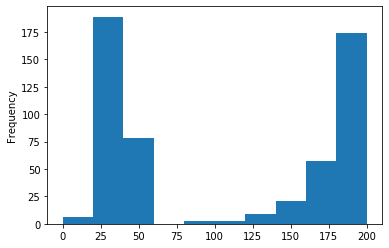

In [41]:
results.gen_len.plot.hist()

### Looks like we have both many short responses and many very long ones, let's see if that significantly impacts our average scores

In [42]:
short_responses = results[results["gen_len"] <= 75]
long_responses = results[results["gen_len"] > 75]

In [120]:
short_responses.groupby('Generation', as_index=False).mean()["Phrasing"].mean()

2.36996336996337

In [119]:
long_responses.groupby('Generation', as_index=False).mean()["Phrasing"].mean()

2.146067415730337

In [118]:
short_responses.groupby('Generation', as_index=False).mean()["Topic"].mean()

2.4835164835164836

In [117]:
long_responses.groupby('Generation', as_index=False).mean()["Topic"].mean()

2.3707865168539324

In [116]:
short_responses.groupby('Generation', as_index=False).mean()["Humanness"].mean()

2.2161172161172162

In [115]:
long_responses.groupby('Generation', as_index=False).mean()["Humanness"].mean()

1.8426966292134832

## We can see an average trend where the long responses tend to be lower rated in all areas, but particularly in humanity

## Lets stratify our data by aggregated ratings

In [192]:
grouped = results.groupby("Generation", as_index=False).mean()

In [193]:
good_human = grouped[round(grouped["Humanness"]) == 3]
med_human = grouped[round(grouped["Humanness"]) == 2]
bad_human = grouped[round(grouped["Humanness"]) == 1]

In [194]:
good_topic = grouped[round(grouped["Topic"]) == 3]
med_topic = grouped[round(grouped["Topic"]) == 2]
bad_topic = grouped[round(grouped["Topic"]) == 1]

In [195]:
good_phrase = grouped[round(grouped["Phrasing"]) == 3]
med_phrase = grouped[round(grouped["Phrasing"]) == 2]
bad_phrase = grouped[round(grouped["Phrasing"]) == 1]

## Lets visualize word clouds

In [148]:
good_words = [s for l in [nltk.word_tokenize(x) for x in good_human["Generation"].values] for s in l if s not in stopwords and s not in string.punctuation]
med_words = [s for l in [nltk.word_tokenize(x) for x in med_human["Generation"].values] for s in l if s not in stopwords and s not in string.punctuation]
bad_words = [s for l in [nltk.word_tokenize(x) for x in bad_human["Generation"].values] for s in l if s not in stopwords and s not in string.punctuation]

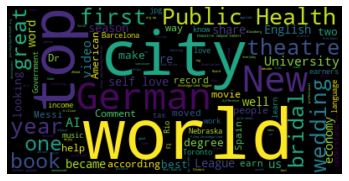

In [149]:
wordcloud = WordCloud().generate(' '.join(good_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

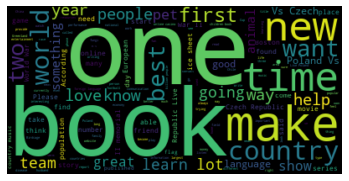

In [150]:
wordcloud = WordCloud().generate(' '.join(med_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

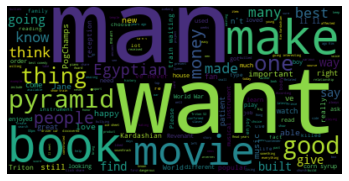

In [151]:
wordcloud = WordCloud().generate(' '.join(bad_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Testing TFIDF

In [137]:
print("Humanness average TFIDF\nGood: {} Med: {} Bad: {}".format(good_human.tfidf_avg.mean(), 
                                         med_human.tfidf_avg.mean(),
                                         bad_human.tfidf_avg.mean()))

Humanness average TFIDF
Good: 0.06952262703157733 Med: 0.04810605136881957 Bad: :0.046832425564410925


In [138]:
print("Topic average TFIDF\nGood: {} Med: {} Bad: {}".format(good_topic.tfidf_avg.mean(),
                                                             med_topic.tfidf_avg.mean(),
                                                             bad_topic.tfidf_avg.mean()))

Topic average TFIDF
Good: 0.05863072590046111 Med: 0.04724188457180085 Bad: 0.04638521125108958


In [139]:
print("Phrasing average TFIDF\nGood: {} Med: {} Bad: {}".format(good_phrase.tfidf_avg.mean(),
                                                             med_phrase.tfidf_avg.mean(),
                                                             bad_phrase.tfidf_avg.mean()))

Phrasing average TFIDF
Good: 0.059546666606560036 Med: 0.0512331370521557 Bad: 0.041881635987509484


### Now lets check if this difference is statistically significant

In [164]:
kruskal(bad_human.tfidf_avg, med_human.tfidf_avg, good_human.tfidf_avg)

KruskalResult(statistic=12.329898384235548, pvalue=0.00210182515116154)

In [165]:
f_oneway(bad_human.tfidf_avg, med_human.tfidf_avg, good_human.tfidf_avg)

F_onewayResult(statistic=5.0103828023453625, pvalue=0.007650840543690355)

In [166]:
tukey = pairwise_tukeyhsd(endog=results["tfidf_avg"],
                          groups=results["label"],
                          alpha=0.05)

In [167]:
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   Bad   Good   0.0141 0.0029  0.0041   0.024   True
   Bad    Med  -0.0009    0.9 -0.0112  0.0094  False
  Good    Med   -0.015 0.0014  -0.025 -0.0049   True
----------------------------------------------------


## Looks like theres only a significant difference between bad and good, and good and medium

## We can see the highest range is from the humanness rating, implying that a high TFIDF is correlated with a high rating of humanity, i.e. using informative unique words gets us a higher rating of humanity

# Testing generation length

In [152]:
print("Humanness average generation length\nGood: {} Med: {} Bad: {}".format(good_human.gen_len.mean(), 
                                         med_human.gen_len.mean(),
                                         bad_human.gen_len.mean()))

Humanness average generation length
Good: 70.65217391304348 Med: 114.22916666666667 Bad: 135.40540540540542


In [153]:
print("Topic average generation length\nGood: {} Med: {} Bad: {}".format(good_topic.gen_len.mean(), 
                                         med_topic.gen_len.mean(),
                                         bad_topic.gen_len.mean()))

Topic average generation length
Good: 98.03092783505154 Med: 116.19117647058823 Bad: 129.71428571428572


In [154]:
print("Phrasing average generation length\nGood: {} Med: {} Bad: {}".format(good_phrase.gen_len.mean(), 
                                         med_phrase.gen_len.mean(),
                                         bad_phrase.gen_len.mean()))

Phrasing average generation length
Good: 87.51470588235294 Med: 115.48351648351648 Bad: 138.3


And a non-parametric statistical test to see if the difference is statistically significant

In [155]:
kruskal(bad_human.gen_len, med_human.gen_len, good_human.gen_len)

KruskalResult(statistic=12.032226205570828, pvalue=0.002439131848496242)

Yep! Now let's see with an ANOVA and a post hoc Tukey's

In [156]:
f_oneway(bad_human.gen_len, med_human.gen_len, good_human.gen_len)

F_onewayResult(statistic=10.07397891115787, pvalue=7.206778448685865e-05)

In [160]:
def label_maker(x):
    if round(x) == 3:
        return "Good"
    elif round(x) == 2:
        return "Med"
    else:
        return "Bad"

In [161]:
results["label"] = results["Humanness"].apply(lambda x: label_maker(x))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [162]:
tukey = pairwise_tukeyhsd(endog=results["gen_len"],
                          groups=results["label"],
                          alpha=0.05)

In [163]:
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   Bad   Good -44.0069  0.001 -61.2244 -26.7893   True
   Bad    Med -19.4454 0.0276 -37.1787  -1.7121   True
  Good    Med  24.5614 0.0026   7.2909   41.832   True
------------------------------------------------------


### We can see a statistical difference between each of the three groups!

## Has a strong effect, again it mostly affects the humanness rating but we can see that the longer the response, the less "human" it is rated on average

## We can then create a post hoc experiment where we prune the generated responses to the first sentence to see how it affects the average humanness ratings

In [168]:
post_hoc = pd.read_csv("/Users/liamgeron/Downloads/Experiment 2.csv")

In [180]:
joined = results.join(post_hoc, on=["ID"], lsuffix='_original', rsuffix='_pruned')

In [183]:
joined.columns = ['worker_id_original', 'ID_original', 'Prompt_original', 'Generation',
       'Phrasing', 'Topic', 'Humanness', 'tokenized', 'gen_len',
       'avg_sent_len', 'unique_word_ratio', 'pos', 'pos_counts', 'common',
       'tfidf', 'tfidf_avg', 'label', 'worker_id_pruned', 'ID_pruned',
       'Prompt_pruned', 'pruned',
       'Phrasing_pruned',
       'Topic_pruned',
       'Human-ness_pruned']

In [185]:
joined["Human-ness_pruned"].describe()

count    537.000000
mean       2.106145
std        0.881981
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Human-ness_pruned, dtype: float64

In [186]:
joined["Humanness"].describe()

count    537.000000
mean       2.037244
std        0.825497
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Humanness, dtype: float64

In [188]:
ttest_ind(joined["Human-ness_pruned"], joined["Humanness"])

Ttest_indResult(statistic=1.3217116747061912, pvalue=0.18654616321325593)

## There is no significant difference in how human the generations are rated with the pruning technique

# Lets see some part of speech features

## My hypothesis is that more adjectives = more "humanness"

In [206]:
print("Humanness proper noun count\nGood: {} Med: {} Bad: {}".format(results[results["Humanness"].apply(lambda x: round(x)) == 3]["pos_counts"].apply(lambda x: x["JJS"]).mean(), 
                                         results[results["Humanness"].apply(lambda x: round(x)) == 2]["pos_counts"].apply(lambda x: x["JJS"]).mean(),
                                         results[results["Humanness"].apply(lambda x: round(x)) == 1]["pos_counts"].apply(lambda x: x["JJS"]).mean()))

Humanness proper noun count
Good: 0.3160621761658031 Med: 0.5263157894736842 Bad: 0.7052023121387283


## Interestingly, it looks like less adjectives = more humanity

In [207]:
kruskal(results[results["Humanness"].apply(lambda x: round(x)) == 3]["pos_counts"].apply(lambda x: x["JJS"]),
        results[results["Humanness"].apply(lambda x: round(x)) == 2]["pos_counts"].apply(lambda x: x["JJS"]),
        results[results["Humanness"].apply(lambda x: round(x)) == 1]["pos_counts"].apply(lambda x: x["JJS"]))

KruskalResult(statistic=5.682203229238658, pvalue=0.05836133883508876)

## But the effect is not statistically significant